In [1]:
from UTILITY_quickstart import *
?initializeTao

Signature:
initializeTao(
    filePath=None,
    lastTrackedElement='end',
    csrTF=False,
    inputBeamFilePathSuffix=None,
    numMacroParticles=None,
    loadDefaultLatticeTF=True,
    runImpactTF=False,
    impactGridCount=32,
)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    numMacroParticles=1e3,
    #loadDefaultLatticeTF=False,

)

trackBeam(tao)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 1000.0


# Optimization

## Utility functions

In [3]:
def propagateToBEGBC20(
    centerXYatBEGBC20 = False    
): 

    ##################################
    #Propagate to BEGBC20 and save result
    ##################################
    makeBeamActiveBeamFile(PInit)
    
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "BEGBC20"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    trackBeam(tao)

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    ##################################
    #Optional!! Center in x and y
    ##################################
    if centerXYatBEGBC20:
        print(f"""Centering beam at BEGBC20, old values (x, xp, y, yp): {P["mean_x"]} ,{P["mean_xp"]}, {P["mean_y"]} ,{P["mean_yp"]} """)
        P.x = P.x - np.mean(P.x)
        P.y = P.y - np.mean(P.y)
        P.px = P.px - np.mean(P.px)
        P.py = P.py - np.mean(P.py)
    
    makeBeamActiveBeamFile(P)

    return

In [4]:
def prepareToSimulateFromBEGBC20toEnd():
    #####################################################
    #Import the BEGBC20 beam and prepare to simulate to end
    #####################################################

    tao.cmd(f'set beam_init track_start = BEGBC20')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

## Optimizer functions

In [5]:
#If we're not making changes upstream, we can just calculate once
makingChangesUpstreamOfBEGBC20 = False

if not makingChangesUpstreamOfBEGBC20:
    setLattice(tao) #Set lattice to current default config
    propagateToBEGBC20(centerXYatBEGBC20 = True)
    prepareToSimulateFromBEGBC20toEnd()

def rampToZero(val, thresh, scale = 1):
    return (max(val, thresh) - thresh) / scale

def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e300  #The value returned for illegal config. Should be colossal. Double limit ~= 1e308
    bigCost  = 1e50   #Should be large enough to dominate any "normal" return value but be dominated by badValue
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue * 5

    if makingChangesUpstreamOfBEGBC20:
        try:
            propagateToBEGBC20(centerXYatBEGBC20 = True)
            prepareToSimulateFromBEGBC20toEnd()
        
        except:
            return badValue * 4

    try:
        trackBeam(tao)

    except:
        return badValue * 3

    BEGBC20NumLiveParticles = tao.bunch_params("BEGBC20")['n_particle_live']
    PENTNumLiveParticles = tao.bunch_params("PENT")['n_particle_live']

    if PENTNumLiveParticles < 10:
        return badValue * 2 

    
    # 2024-05-22 NO NO NO! These bunch_params calls are actually returning lattice info because fuck me
    #PENTEmitX = tao.bunch_params("PENT")['twiss_norm_emit_x']
    #PENTEmitY = tao.bunch_params("PENT")['twiss_norm_emit_y']
    #PENTSigmaZ = tao.bunch_params("PENT")['twiss_sigma_z']

    # PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
    # PPENT = PPENT[PPENT.status==1]

    # PENTEmitX = PPENT["norm_emit_x"]
    # PENTEmitY = PPENT["norm_emit_y"]
    # PENTSigmaZ = PPENT["sigma_t"]*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z
    
    try: 
        P = getBeamAtElement(tao, "PENT")
        PDrive, PWitness = getDriverAndWitness(P)
    

        for PActiveStr in ["PDrive", "PWitness"]:
            PActive = locals()[PActiveStr]
            for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
                savedData[f"{PActiveStr}_{val}"] = PActive[val]
                #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

            #Note that this is not a standard deviation; also imposes cost for being off zero
            savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
            savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


            #Using the product was making it report flat beams...
            #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
            #Instead, average
            savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

            savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
            savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

            savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

            savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

        savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]
            

    except:
        return badValue


    #Linear cost, weight by bunch
    #driveCostWeight = 0.1    
    #maximizeMe = 1 / (savedData["PWitness_totalCost"] + driveCostWeight * savedData["PDrive_totalCost"])

    #Ramp function cost
    targetBunchSpacing = 150e-6
    
    tolerableBeamOffset = 5e-6
    
    witnessTransverseSizeCostThreshold = 20e-6
    driveTransverseSizeCostThreshold = 20e-6

    driveEmittanceThreshold = 50e-6
    witnessEmittanceThreshold = 20e-6
    
    driveLengthCostThreshold =  0
    witnessLengthCostThreshold = 0

    

    # maximizeMe = 1 / (
    #     max(witnessCostThreshold, np.sqrt(savedData["PWitness_xCost"])) *  
    #     max(witnessCostThreshold, np.sqrt(savedData["PWitness_yCost"]))
    #     + driveCostWeight * savedData["PDrive_totalCost"]
    # )  


    #Using the product was making it prefer flat beams...
    # savedData["maximizeMe"] = 1 / (
    #     max(witnessTransverseSizeCostThreshold, np.sqrt(savedData["PWitness_xCost"])) +  
    #     max(witnessTransverseSizeCostThreshold, np.sqrt(savedData["PWitness_yCost"])) +
    #     driveTransverseCostWeight * np.sqrt(savedData["PDrive_xCost"]) +
    #     driveTransverseCostWeight * np.sqrt(savedData["PDrive_yCost"]) +
    #     max(driverLengthCostThreshold,  savedData["PDrive_zLen"]   ) +
    #     max(witnessLengthCostThreshold, savedData["PWitness_zLen"] ) 
    # )

    savedData["maximizeMe"] = 1 / np.mean([
        1e6 * rampToZero( abs(savedData["bunchSpacing"] - targetBunchSpacing), 10e-6, scale = 10e-6), 
        
        # 1e3 * rampToZero(abs(savedData["PWitness_mean_x"]), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PWitness_mean_y"]), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PDrive_mean_x"]  ), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PDrive_mean_y"]  ), tolerableBeamOffset, scale = 1e-6),

        1e3 * rampToZero(
            np.sqrt(
                (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
                (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
            ), 
            tolerableBeamOffset, scale = 1e-6),
  
        # rampToZero(savedData["PWitness_sigma_x"], witnessTransverseSizeCostThreshold, scale = 10e-6),  
        # rampToZero(savedData["PWitness_sigma_y"], witnessTransverseSizeCostThreshold, scale = 10e-6),
        # rampToZero(savedData["PDrive_sigma_x"],   driveTransverseSizeCostThreshold, scale = 10e-6), 
        # rampToZero(savedData["PDrive_sigma_y"],   driveTransverseSizeCostThreshold, scale = 10e-6),

        rampToZero(savedData["PDrive_emitSI90_x"],   driveEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PDrive_emitSI90_y"],   driveEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PWitness_emitSI90_x"], witnessEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PWitness_emitSI90_y"], witnessEmittanceThreshold, scale = 10e-6),
        
        
        rampToZero(savedData["PDrive_zLen"],   driveLengthCostThreshold,   scale = 10e-6),
        rampToZero(savedData["PWitness_zLen"], witnessLengthCostThreshold,  scale = 10e-6) 
    ])
    
    

    #Use charge loss to impose cost
    worstNumLiveParticles = PENTNumLiveParticles
    chargeFractionLiving = worstNumLiveParticles / BEGBC20NumLiveParticles

    
    if chargeFractionLiving < 0.98:
        #If a gradient is desired
        #savedData["maximizeMe"] += bigCost * (1-chargeFractionLiving)

        #If it's just a threshold
        return badValue*0.5
  
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    #Optional: Write to file
    self.history.to_json('optimizerHistory.json', orient='records')
    
    self.updatePlot()


    return savedData["maximizeMe"]



def optimizerWrapper( self,
                     L1PhaseSet, L2PhaseSet, 
                     #B1EkG, B2EkG, B3EkG,
                     Q1EkG, Q2EkG, Q3EkG, Q4EkG, Q5EkG, Q6EkG,
                     S1ELkG, S2ELkG, S3ELkG, 
                     S3ERkG, S2ERkG, S1ERkG,
                     **kwargs ):
    return specificOptimizer(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            
            #"B1EkG": B1EkG,
            #"B2EkG": B2EkG,
            #"B3EkG": B3EkG,
            
            "Q1EkG" : Q1EkG,
            "Q2EkG" : Q2EkG,
            "Q3EkG" : Q3EkG,
            "Q4EkG" : Q4EkG,
            "Q5EkG" : Q5EkG,
            "Q6EkG" : Q6EkG,
            
            "S1ELkG": S1ELkG,
            "S2ELkG": S2ELkG,
            "S3ELkG": S3ELkG,
            "S3ERkG": S3ERkG,
            "S2ERkG": S2ERkG,
            "S1ERkG": S1ERkG,
            # "S3ERkG": S3ELkG, #Symmetry approx
            # "S2ERkG": S2ELkG, #Symmetry approx
            # "S1ERkG": S1ELkG, #Symmetry approx
            
        }
    )

Centering beam at BEGBC20, old values (x, xp, y, yp): -2.584999133928119e-05 ,-1.7561170587385376e-06, 2.271192649424458e-06 ,-4.152116392756203e-07 


## Do optimization

### General optimizer setup

In [6]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None


    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

In [7]:
def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
#boundsRange = 0.5
quadBoundsRange = 0.5
sextBoundsRange = 1

In [8]:
# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
# pbounds = {
#     #'L1PhaseSet': (-40, -20),
#     #'L2PhaseSet': (-50, -30),
    
#     #"B1EkG": makeBoundsTuple(boundsRange, 7.533),
#     #"B2EkG": makeBoundsTuple(boundsRange, -10.942),
#     #"B3EkG": makeBoundsTuple(boundsRange, 3.409),

#     "Q1EkG": makeBoundsTuple(quadBoundsRange, 161.311),
#     "Q2EkG": makeBoundsTuple(quadBoundsRange, -154.229),
#     "Q3EkG": makeBoundsTuple(quadBoundsRange, 110.217),
#     "Q4EkG": makeBoundsTuple(quadBoundsRange, 132.268),
#     "Q5EkG": makeBoundsTuple(quadBoundsRange, -23.373),
#     "Q6EkG": makeBoundsTuple(quadBoundsRange, -142.271),

#      "S1ELkG": makeBoundsTuple(sextBoundsRange, 804.871),
#      "S2ELkG": makeBoundsTuple(sextBoundsRange, -2049.489),
#      "S3ELkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
#      "S3ERkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
#      "S2ERkG": makeBoundsTuple(sextBoundsRange, -2049.489),
#      "S1ERkG": makeBoundsTuple(sextBoundsRange, 804.871),
# }

In [9]:
pbounds = {
    'L1PhaseSet': (-30, -10),
    'L2PhaseSet': (-48, -28),
    
    #"B1EkG": makeBoundsTuple(boundsRange, 7.533),
    #"B2EkG": makeBoundsTuple(boundsRange, -10.942),
    #"B3EkG": makeBoundsTuple(boundsRange, 3.409),

    "Q1EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q1EL")),
    "Q2EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q2EL")),
    "Q3EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q3EL_1")),
    "Q4EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q4EL_1")),
    "Q5EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q5EL")),
    "Q6EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q6E")),
    
    "S1ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S1EL")),
    "S2ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S2EL")),
    "S3ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S3EL_1")),
    "S3ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S3ER_1")),
    "S2ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S2ER")),
    "S1ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S1ER")),
}

### Bayesian optimization

In [10]:
# optimizer = bayes_opt.BayesianOptimization(
#     f=problem.optimizerWrapper,
#     pbounds=pbounds,
#     random_state=7,
#     allow_duplicate_points=True, #2024-04-26 it was whining about this,
#     verbose = 0 #2024-05-22: Make it quiet
# )

# #Initial point(s) to check
# optimizer.probe(
#     params={
# 'Q1EkG': 117.05888832887702,
#  'Q2EkG': -161.08070347179788,
#  'Q3EkG': 123.62696608961151,
#  'Q4EkG': 99.94203817364581,
#  'Q5EkG': -31.456534919110677,
#  'Q6EkG': -105.01493924928589,
#  'S1ELkG': 453.142910378237,
#  'S2ELkG': -1988.4701652598128,
#  'S3ELkG': -985.7586439934659,
#  'S3ERkG': -564.5394965036853,
#  'S2ERkG': -1592.1135118613981,
#  'S1ERkG': 869.2610562040793
# },
#     lazy=True,
# )

# #Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# #and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
# boInitialKappa = 10 + 0*10.
# boFinalKappa = 1e-3 + 0*0.1
# boNumIter = 1000
# boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

# acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
#                                    kappa=boInitialKappa,         #Default 2.576
#                                    xi=0.0,              #Default 0
#                                    kappa_decay=boKappaDecay,       #Default 0
#                                    kappa_decay_delay=0  #Default 0                     
#                                           )


# optimizer.maximize(
#     init_points=0, #Initial, random points
#     n_iter=boNumIter,
#     acquisition_function=acquisition_function
# )

### Differential evolution

In [11]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evolution is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

'Total Num Evals: 84'

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


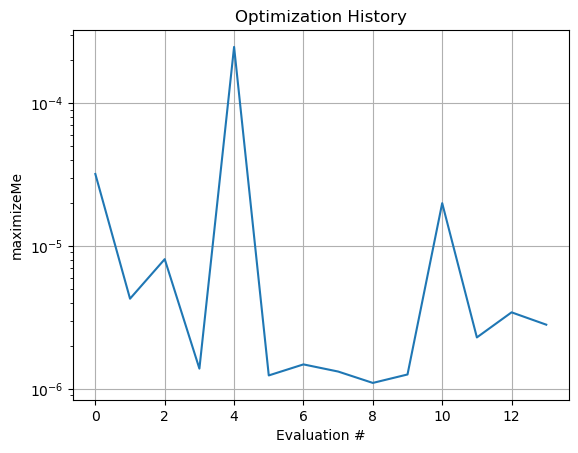

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found
WARNING! Expected drive/witness structure not found


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
#Optional: Define list of starting points
totalPopSize = 100  # Total population size
numDimensions = len(bounds)  # Number of parameters

#Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]
    mean = (high + low) / 2
    std_dev = (high - low) / 20
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
populationDE = np.vstack([[ np.mean(i) for i in bounds ], populationDE])

result = differential_evolution(
    wrapperDE, 
    bounds,
    maxiter=20, 
    disp=True,
    polish = False, 
    init = populationDE
)


print(problem.history) 

## Check out results

In [ ]:
problem.history.to_csv('output_data.csv', index=False)

problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)


bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 



setLattice(tao, **bestConfigDict)


trackBeam(tao)

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

In [ ]:
bestConfigDict

In [ ]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'delta_t', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))


In [ ]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'delta_t', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


In [ ]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))

In [ ]:
P = getBeamAtElement(tao, "MFFF")

display(plotMod(P, 'x', 'xp', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))